In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

# PATH = "../blockchainnode/db_nodes"
# PATH = "/Users/jwheo/Projects/bcsos/PoS_20221130_083413"
PATH = "/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
if len(fdbs) == 0:
    subdirs = [x[0] for x in os.walk(PATH)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'db']
        fdbs.extend(subbs)

fdbs.sort()
print(fdbs)

['/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node0.local/7031.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node1.local/7032.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node2.local/7033.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node3.local/7034.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node4.local/7035.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node5.local/7036.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node6.local/7037.db', '/Users/jwheo/Projects/bcsos/PoS_Ext_64_20230915_083007/node7.local/7038.db']


[31, 25, 27, 29, 26, 37, 31, 42] 248
[31, 28, 30, 40, 31, 26, 30, 23] 239
Fairness Proof 0.9656825637143578
Fairness Verification 0.9732887820700705
Entropy Proof 0.9928523637282661
Entropy Verification 0.9944172117891416


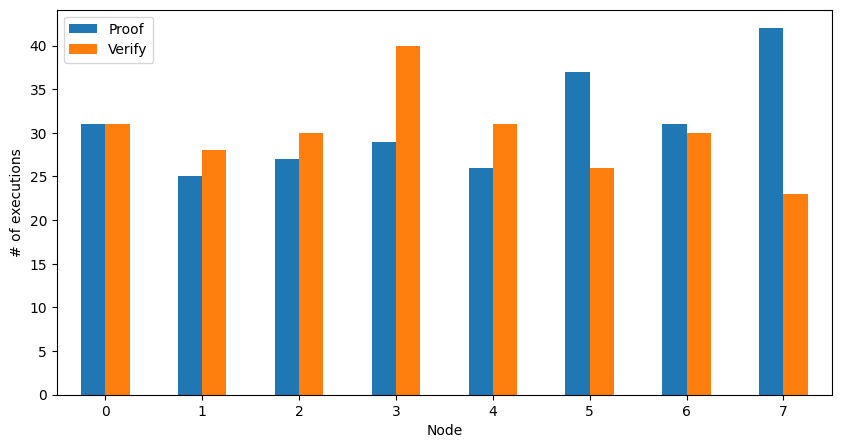

In [4]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




Avg Proof[msec] 17.004651119143794
Avg Verif Fwd[msec] 16351.941826910737
Avg Verif Back[msec] 737.6012497851463


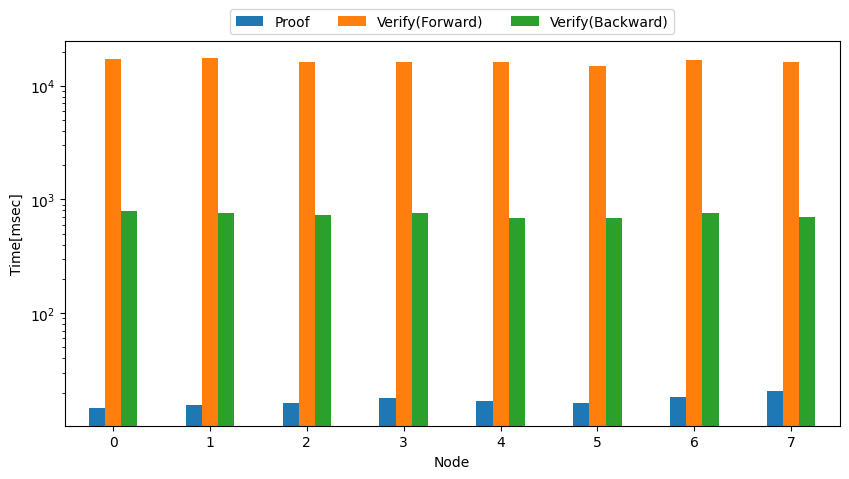

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(Forward)', 'Verify(Backward)']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Time[msec]")
# plt.legend(loc='right')
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif Fwd[msec]', sum(veriffwd)/len(veriffwd))
print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


[883.3272258064517, 986.55552, 871.1173333333334, 900.5166896551724, 923.6883076923077, 965.2825945945946, 978.7287741935484, 998.6043809523809]
Avg size of proof 938.4776032784736


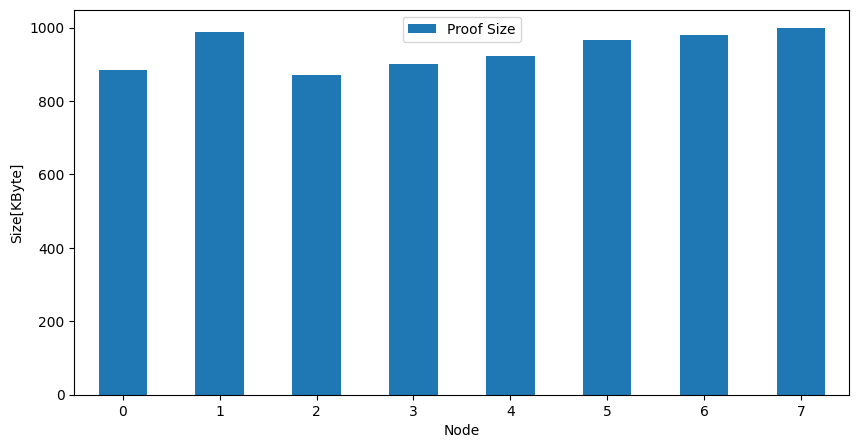

In [6]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))


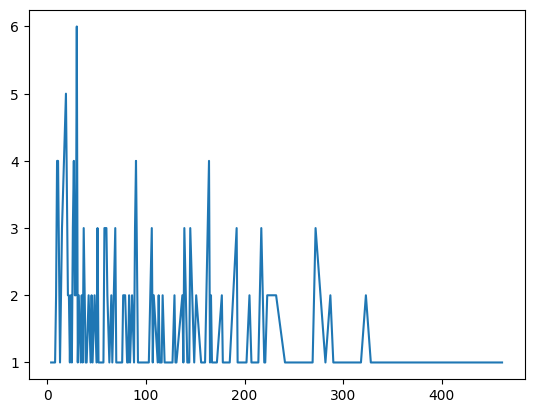

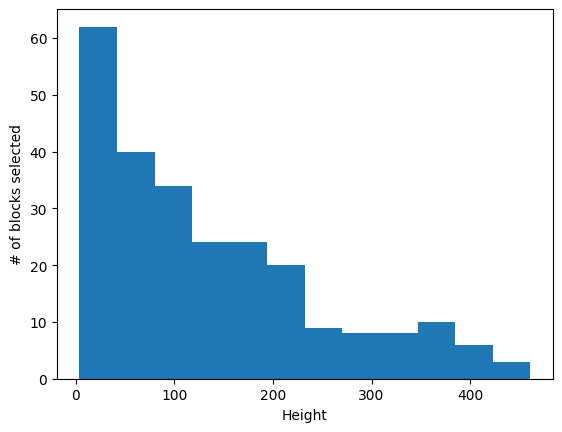

In [7]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

plt.plot(bdf2['Height'], bdf2['Count'])

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()

plt.xlabel("Height")
plt.ylabel("# of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



0.7968225169905172 0.9785779089549749
0.6426583977043098 0.9484481599336917
0.7487949668475307 0.9699825185919877


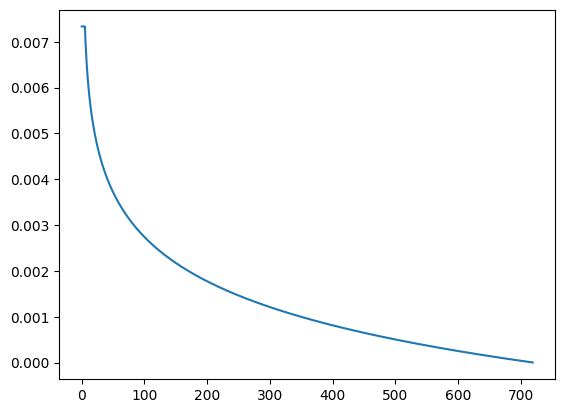

In [8]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt1'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt1'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt2'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt2'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    # mpis = max(pis)
    mpis = sum(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis3 = [-np.log2(x) for x in pis2] 
    # print(pis2)
    plt.plot(pis2)
    return pis2, pis3

def cal_evenness3(vdf, vmax):
    # vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    # vdf['weight3'] = [pis2[v] for v in vdf['Height'].values]
    vdf['weight3'] = [1/pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt3'] = vdf['Count']*vdf['weight3']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']

    # plt.plot(vdf['weight3'])

    # values = vdf['Count'].to_list()
    # vs = np.array(values)
    # num = vs.size
    # tt = np.sum(vs)
    # vs = vs/tt
    # # print('p(x)', vs)

    # ci_values =  vdf['weight3'].to_list()
    # ci = np.array(ci_values)
    # # print('CI=====', ci)

    # se = vs*ci
    # npi = np.sum(vs*ci)
    # dpi = math.log2(num)
    # print('Entropy', npi/dpi)
    # plt.plot(vs, 'g')
    # # plt.plot(ci, 'r')
    # plt.plot(se, 'b')

    values = vdf['norm_cnt3'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    # plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)

# print(bdf2)
# plt.plot(bdf2['norm_cnt1']*50, 'r')
# plt.plot(bdf2['norm_cnt2']/1284, 'b')
# plt.plot(bdf2['norm_cnt3']/20, 'g')



In [9]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt1,norm_cnt2,weight3,norm_cnt3
0,4,1,716,0.001397,4,136.372023,136.372023
1,8,1,712,0.001404,8,154.248142,154.248142
2,9,2,711,0.002813,18,159.078862,318.157724
3,10,4,710,0.005634,40,163.560942,654.243769
4,11,4,709,0.005642,44,167.762492,671.049967
...,...,...,...,...,...,...,...
159,408,1,312,0.003205,408,1273.991452,1273.991452
160,410,1,310,0.003226,410,1285.064624,1285.064624
161,424,1,296,0.003378,424,1366.619115,1366.619115
162,449,1,271,0.003690,449,1532.542539,1532.542539


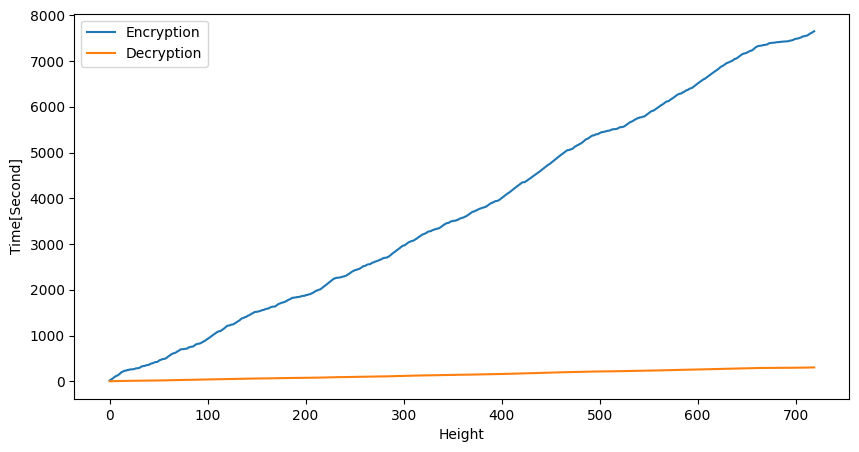

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

df = pd.read_csv('../ppos.divid.csv', header=None)
df = df.rename(columns={0: "Encryption", 1: "Decryption"})

# df1 = pd.read_csv('../ppos.size.csv', header=None)
# df1 = df1.rename(columns={0: "Encryption", 1: "Decryption", 2: "Size"})

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['Encryption']/1000, label="Encryption")
ax.plot(df['Decryption']/1000, label="Decryption")

# twin1 = ax.twinx()
# twin1.plot(df1['Size'], "g-.", label="Size")

ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel("Height")
plt.ylabel("Time[Second]")
plt.legend()
plt.savefig('Encrypt_Height.png', dpi=300, bbox_inches='tight')


======== 56
======== 64
======== 48
======== 40
======== 32
      Encoding   Decoding           Size  GF
0  1145.913021  55.402431  133752.644444  32
0  1427.336458  52.999306  133753.180556  40
0  1703.572222  50.946875  133753.650000  48
0  1973.581076  49.402778  133754.152778  56
0  2239.847396  47.851562  133754.600000  64


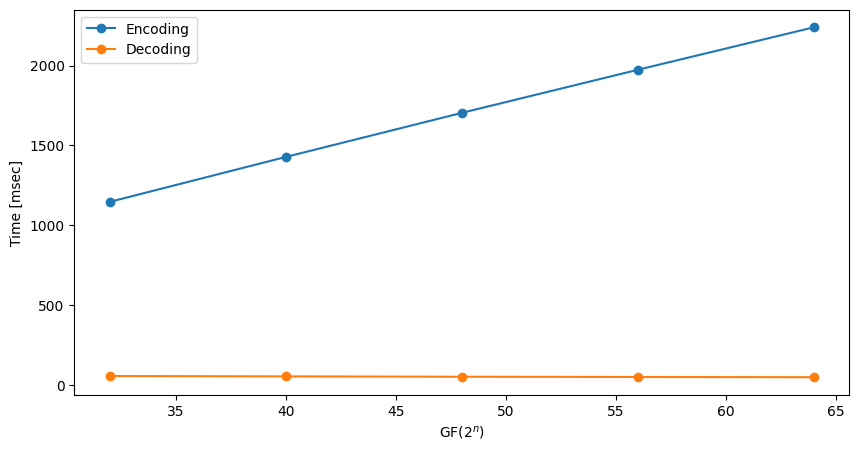

In [17]:
import os
import pandas as pd
from matplotlib import pyplot as plt

PATH = "../ppos_ext"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[0].find('MLDC_') == 0]
dbs = {}
for i, f in enumerate(fdbs):
    key = f.split('_')[-1]
    print("========", key)
    tdbs = []    
    subdirs = [x[0] for x in os.walk(f)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'csv']
        if len(subbs) > 0 and subbs[0].find('.csv') != -1:
            tdbs.append(subbs[0])            
    dbs[key] = tdbs
gfs = list(dbs.keys())
gfs.sort()

dfcs = pd.DataFrame()
for g in gfs:
    ss = dbs[g]
    dfg = pd.DataFrame()
    for s in ss:        
        df = pd.read_csv(s, header=None)
        df.rename(columns = {0:'Encoding', 1:'Decoding', 2:"Size"}, inplace = True)
        m = df.mean()
        dfg = pd.concat([dfg, pd.DataFrame(m).transpose()], axis=0)
    dfc = pd.DataFrame(dfg.mean()).transpose()
    dfc["GF"] = int(g)
    dfcs = pd.concat([dfcs, dfc], axis=0)
print(dfcs)

plt.figure(figsize=(10,5))
plt.plot( dfcs['GF'], dfcs['Encoding'], marker='o', label="Encoding")
plt.plot( dfcs['GF'], dfcs['Decoding'], marker='o', label="Decoding")
plt.legend(loc="upper left")
plt.ylabel("Time [msec]")
plt.xlabel("GF($2^n$)")
plt.show()
# print(fdbs)